In [1]:
import sys
import datacube
import numpy as np
from odc.ui import select_on_a_map
from ipyleaflet import basemaps, basemap_to_tiles

sys.path.append('../../Scripts')
from dea_datahandling import load_ard
from dea_datahandling import mostcommon_crs

from dea_plotting import xr_animation
from dea_coastaltools import tidal_tag
from skimage.color import rgb2hsv, hsv2rgb

def hue_sat_val(rgb_array,
                hue_mult=1, 
                sat_mult=0.8, 
                val_mult=1):   
    
    # Convert to HSV and multiply bands
    hsv_array = rgb2hsv(rgb_array)
    hsv_array[:, :, 0] = hsv_array[:, :, 0] * hue_mult
    hsv_array[:, :, 1] = hsv_array[:, :, 1] * sat_mult
    hsv_array[:, :, 2] = hsv_array[:, :, 2] * val_mult
    
    # Convert back to RGB
    return hsv2rgb(hsv_array.clip(0, 1))



dc = datacube.Datacube(app='Animated timeseries' )



%load_ext autoreload
%autoreload 2

/env/lib/python3.6/site-packages/geopandas/_compat.py:110: UserWarning: The Shapely GEOS version (3.7.2-CAPI-1.11.0 ) is incompatible with the GEOS version PyGEOS was compiled with (3.9.1-CAPI-1.14.2). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string
/env/lib/python3.6/site-packages/datacube/drivers/postgres/_connections.py:87: SADeprecationWarning: Calling URL() directly is deprecated and will be disabled in a future release.  The public constructor for URL is now the URL.create() method.
  username=username, password=password,


In [2]:
# Configure local dask cluster
from dea_dask import create_local_dask_cluster
create_local_dask_cluster()

# # Create dask gateway cluser
# from dea_tools.dask import create_dask_gateway_cluster
# cluster = create_dask_gateway_cluster()

Client Scheduler: tcp://127.0.0.1:40933 Dashboard: /user/robbibt/proxy/8787/status,Cluster Workers: 1 Cores: 15 Memory: 125.85 GB


In [3]:
from odc.ui import select_on_a_map
from ipyleaflet import basemaps, basemap_to_tiles

# Plot interactive map to select area
basemap = basemap_to_tiles(basemaps.Esri.WorldImagery)
geopolygon = select_on_a_map(height='600px',
                             layers=(basemap,),
                             center=(-26, 135), 
                             zoom=4) 

Map(center=[-26, 135], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_t…

In [20]:
# bands=['nbart_red', 'nbart_green', 'nbart_blue']
bands=['nbart_swir_1', 'nbart_nir', 'nbart_green', 'nbart_red']

time = ('1986', '2021-12-31')

# Obtain native CRS 
crs = mostcommon_crs(dc=dc, 
                     product='ga_ls5t_ard_3', 
                     query={'time': '1990', 
                            'geopolygon': geopolygon})

query = {
    'geopolygon': geopolygon,
    'time': time,
    'measurements': bands,
    'resampling': {'fmask': 'nearest', 
                   'oa_fmask': 'nearest', 
                   '*': 'nearest'},
    'output_crs': crs,
    'resolution': (-30, 30),
    'group_by': 'solar_day',
    'dask_chunks': {'time': 1, 'x': 3000, 'y': 3000}
}

# # Landsat upscaled res
# query = {
#     'geopolygon': geopolygon,
#     'time': time,
#     'measurements': bands,
#     'resampling': {'fmask': 'nearest', 
#                    'oa_fmask': 'nearest', 
#                    '*': 'cubic'},
#     'output_crs': crs,
#     'resolution': (-10, 10),
#     'group_by': 'solar_day',
#     'dask_chunks': {'time': 1, 'x': 3000, 'y': 3000}
# }

# # Sentinel-2 10m
# crs = mostcommon_crs(dc=dc, 
#                      product='s2a_ard_granule', 
#                      query={'time': '2018', 
#                             'geopolygon': geopolygon})

# query = {
#     'geopolygon': geopolygon,
#     'time': time,
#     'measurements': bands,
#     'resampling': {'fmask': 'nearest', 
#                    'oa_fmask': 'nearest', 
#                    '*': 'cubic'},
#     'output_crs': crs,
#     'resolution': (-20, 20),
#     'group_by': 'solar_day',
#     'dask_chunks': {'time': 1, 'x': 3000, 'y': 3000}
# }

ds_ls = load_ard(dc=dc,
                 products=[
                           'ga_ls5t_ard_3', 'ga_ls7e_ard_3', 'ga_ls8c_ard_3', 
#                            's2a_ard_granule', 's2b_ard_granule', 's2a_nrt_granule', 's2b_nrt_granule'
                          ],
                 min_gooddata=0.99,
                 ls7_slc_off=False,
                 mask_pixel_quality=False,
                 **query)


# ds_ls = tidal_tag(ds_ls)
# ds_ls = ds_ls.sel(time = ds_ls.tide_height < ds_ls.tide_height.median())
ds_ls = ds_ls.compute()
ds_ls


# dss_ls5 = dc.find_datasets(product='ls5_nbart_geomedian_annual', **query)
# dss_ls7 = dc.find_datasets(product='ls7_nbart_geomedian_annual', **query)
# dss_ls8 = dc.find_datasets(product='ls8_nbart_geomedian_annual', **query)
# dss = dss_ls5 + dss_ls7 + dss_ls8

# ds = dc.load(datasets=dss,
#              measurements=['red', 'green', 'blue'],
#              output_crs='EPSG:3577',
#              resolution=(-30, 30),
#              **query)
# ds


/home/jovyan/Robbi/dea-notebooks/Testing/Animations/../../Tools/dea_tools/datahandling.py:237: UserWarning: Setting 'min_gooddata' percentage to > 0.0 will cause dask arrays to compute when loading pixel-quality data to calculate 'good pixel' percentage. This can slow the return of your dataset.
  warnings.warn("Setting 'min_gooddata' percentage to > 0.0 "


Finding datasets
    ga_ls5t_ard_3
    ga_ls7e_ard_3 (ignoring SLC-off observations)
    ga_ls8c_ard_3
Counting good quality pixels for each time step
Filtering to 171 out of 1198 time steps with at least 99.0% good quality pixels
Returning 171 time steps as a dask array


<xarray.Dataset>
Dimensions:       (time: 171, x: 1026, y: 865)
Coordinates:
  * time          (time) datetime64[ns] 1987-07-28T00:30:32.039253 ... 2021-0...
  * y             (y) float64 -1.619e+06 -1.619e+06 ... -1.645e+06 -1.645e+06
  * x             (x) float64 5.202e+05 5.202e+05 ... 5.509e+05 5.51e+05
    spatial_ref   int32 32653
Data variables:
    nbart_swir_1  (time, y, x) int16 3977 4080 4046 4321 ... 115 122 117 121
    nbart_nir     (time, y, x) int16 2956 3150 3247 3295 ... 595 628 596 563
    nbart_green   (time, y, x) int16 1834 2111 2295 2387 ... 1597 1615 1613 1606
    nbart_red     (time, y, x) int16 2320 2654 2821 2904 ... 1685 1705 1691 1676
Attributes:
    crs:           epsg:32653
    grid_mapping:  spatial_ref

In [21]:
ds_rolling = ds_ls.rolling(time=40, center=True, min_periods=1).median()
# ds_rolling = ds_ls.resample(time='Y').median(dim='time').rolling(time=3, center=True, min_periods=1).median()
median_array = np.transpose(ds_rolling[bands]
                            .median(dim='time')
                            .to_array().values, 
                            axes=(1, 2, 0))
print(ds_rolling)

<xarray.Dataset>
Dimensions:       (time: 171, x: 1026, y: 865)
Coordinates:
  * time          (time) datetime64[ns] 1987-07-28T00:30:32.039253 ... 2021-0...
  * y             (y) float64 -1.619e+06 -1.619e+06 ... -1.645e+06 -1.645e+06
  * x             (x) float64 5.202e+05 5.202e+05 ... 5.509e+05 5.51e+05
    spatial_ref   int32 32653
Data variables:
    nbart_swir_1  (time, y, x) float32 3864.5 3897.5 3992.0 ... 83.0 83.0 82.0
    nbart_nir     (time, y, x) float32 2972.0 2984.0 3031.5 ... 271.0 265.0
    nbart_green   (time, y, x) float32 1768.0 1769.5 1808.5 ... 1383.0 1373.0
    nbart_red     (time, y, x) float32 2269.0 2270.5 2295.0 ... 817.0 816.0


## Run animation

In [22]:
import numpy as np
from skimage.filters import unsharp_mask
from skimage.exposure import match_histograms, rescale_intensity, adjust_sigmoid

ndvi = (ds_rolling["nbart_nir"] - ds_rolling["nbart_red"])/(ds_rolling["nbart_nir"] + ds_rolling["nbart_red"])
ds_rolling2 = ds_rolling * rescale_intensity(image=ndvi, in_range=(0, 0.8), out_range=(0, 1.0))



In [25]:
ds_rolling2

<xarray.Dataset>
Dimensions:       (time: 171, x: 1026, y: 865)
Coordinates:
  * time          (time) datetime64[ns] 1987-07-28T00:30:32.039253 ... 2021-0...
  * y             (y) float64 -1.619e+06 -1.619e+06 ... -1.645e+06 -1.645e+06
  * x             (x) float64 5.202e+05 5.202e+05 ... 5.509e+05 5.51e+05
    spatial_ref   int32 32653
Data variables:
    nbart_swir_1  (time, y, x) float64 648.0 661.5 690.0 624.1 ... 0.0 0.0 0.0
    nbart_nir     (time, y, x) float64 498.3 506.5 524.0 484.3 ... 0.0 0.0 0.0
    nbart_green   (time, y, x) float64 296.4 300.3 312.6 283.4 ... 0.0 0.0 0.0
    nbart_red     (time, y, x) float64 380.4 385.4 396.7 371.3 ... 0.0 0.0 0.0

Exporting animation to animation_bowling.mp4


  0%|          | 0/141 (0.0 seconds remaining at ? frames/s)

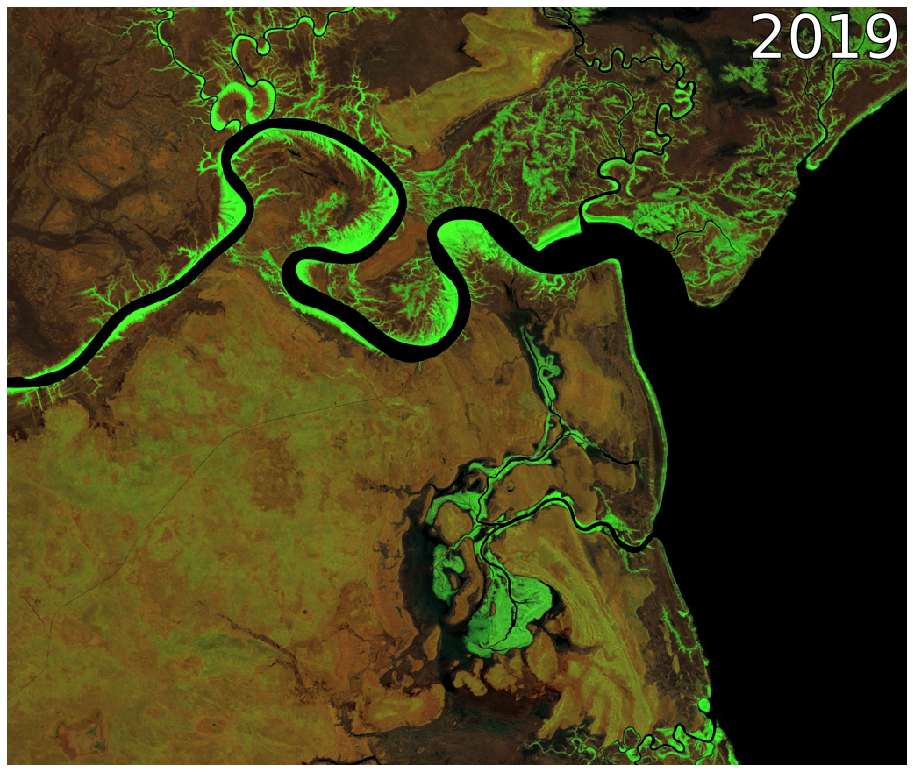

In [33]:
funcs_list = [
#               lambda x: match_histograms(image=x, reference=median_array, multichannel=True),
#               lambda x: x**0.8,
#               ndvi_mult,
              rescale_intensity,
#               hue_sat_val,
#               lambda x: unsharp_mask(x, radius=20, amount=0.2),
#               lambda x: unsharp_mask(x, radius=5, amount=0.1),
#               lambda x: adjust_sigmoid(image=x, cutoff=0.7, gain=3)
             ]
funcs_list = None

xr_animation(output_path='animation_bowling.mp4',
             ds=ds_rolling2.isel(time=slice(20, -10)),
             show_text='',
             bands=bands[0:3],
             interval=50,
             width_pixels=900,
             percentile_stretch=(0.001, 0.999),
             image_proc_funcs=funcs_list,
             show_date='%Y',
             annotation_kwargs={'fontsize': 60},
#              show_gdf=deacl_gdf,
#              gdf_kwargs = {'linewidth': 2.5},
#              imshow_kwargs={'vmin': -0.5, 'vmax': 0.7},   # Stuart Point, Twilight Bay
#              imshow_kwargs={'vmin': -0.2, 'vmax': 0.6},
#              limit=20,
            ) 

## DEA CoastLines data

/env/lib/python3.6/site-packages/geopandas/geodataframe.py:577: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


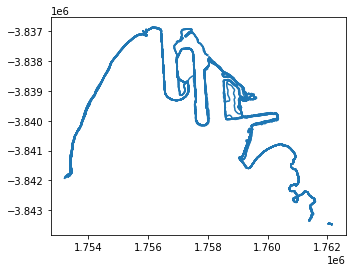

In [6]:
import geopandas as gpd
import pandas as pd
import matplotlib

# Get bounding box of data
xmin, ymin, xmax, ymax = ds_ls.geobox.geographic_extent.boundingbox

# Set up WFS requests for annual coastlines & rates of change statistics
deacl_coastlines_wfs = 'https://geoserver.dea.ga.gov.au/geoserver/wfs?' \
                       'service=WFS&version=1.1.0&request=GetFeature&' \
                       'typeName=dea:coastlines&maxFeatures=1000&' \
                      f'bbox={ymin},{xmin},{ymax},{xmax},urn:ogc:def:crs:EPSG:4326'

# Load data from WFS and set CRS
deacl_gdf = gpd.read_file(deacl_coastlines_wfs)
deacl_gdf.crs = 'EPSG:3577'

# Clip to extent of satellite data
bbox = gpd.GeoDataFrame(geometry=[ds_ls.geobox.extent.geom],
                        crs=ds_ls.geobox.crs)  
deacl_gdf = gpd.overlay(deacl_gdf, bbox.to_crs(deacl_gdf.crs))
deacl_gdf = deacl_gdf.dissolve('year')

# Apply colours
norm = matplotlib.colors.Normalize(vmin=0, vmax=len(deacl_gdf.index))
cmap = matplotlib.cm.get_cmap('inferno')
rgba = cmap(norm(deacl_gdf.reset_index().index))
deacl_gdf['color'] = list(rgba)
deacl_gdf['start_time'] = (pd.to_datetime(deacl_gdf.index) + 
                           pd.DateOffset(months=5))

# Remove a year
# deacl_gdf = deacl_gdf.drop('1993')

deacl_gdf.plot()

In [ ]:
# minx, miny, maxx, maxy = deacl_gdf.unary_union.bounds
# from shapely.geometry import box
# import geopandas as gpd
# test = box(minx, -3570200, maxx, maxy)
# deacl_gdf = gpd.clip(deacl_gdf, gpd.GeoSeries(test, crs='EPSG:3577')) 
# deacl_gdf.plot()

In [ ]:
import numpy as np
from skimage.filters import unsharp_mask
from skimage.exposure import match_histograms, rescale_intensity, adjust_sigmoid

funcs_list = [lambda x: match_histograms(image=x, reference=median_array, multichannel=True),
#               lambda x: x**0.5,
              rescale_intensity,
#               hue_sat_val,
              lambda x: unsharp_mask(x, radius=20, amount=0.3),
              lambda x: unsharp_mask(x, radius=5, amount=0.2),
#               lambda x: adjust_sigmoid(image=x, cutoff=0.7, gain=3)
             ]
# funcs_list = None

xr_animation(output_path='deacoastlines_annual_pelicanpoint.mp4',
             ds=ds_rolling,  #.isel(time=slice(10, -1)),
             show_text='',
             bands=bands,
             interval=80,
             width_pixels=900,
             percentile_stretch=(0.01, 0.99),
             image_proc_funcs=funcs_list,
             show_date='%Y',
             annotation_kwargs={'fontsize': 55},
             show_gdf=deacl_gdf,
             gdf_kwargs = {'linewidth': 2.5},
             imshow_kwargs={'vmin': -0.5, 'vmax': 0.7},   # Stuart Point, Twilight Bay
#              imshow_kwargs={'vmin': -0.2, 'vmax': 0.6},
#              limit=30,
            ) 

Applying custom image processing functions


  0%|          | 0/305 (0.0 seconds remaining at ? frames/s)

Exporting animation to animation_sydney.mp4


  0%|          | 0/305 (0.0 seconds remaining at ? frames/s)

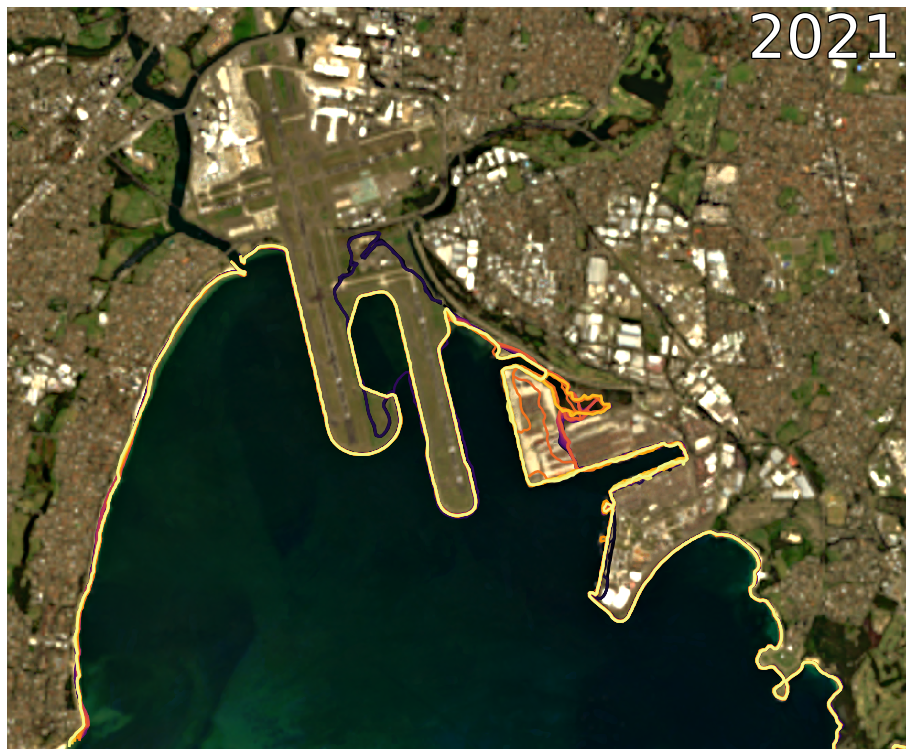

In [8]:
import numpy as np
from skimage.filters import unsharp_mask
from skimage.exposure import match_histograms, rescale_intensity, adjust_sigmoid

funcs_list = [
              lambda x: match_histograms(image=x, reference=median_array, multichannel=True),
              lambda x: x**0.8,
              rescale_intensity,
#               hue_sat_val,
              lambda x: unsharp_mask(x, radius=20, amount=0.2),
              lambda x: unsharp_mask(x, radius=5, amount=0.1),
#               lambda x: adjust_sigmoid(image=x, cutoff=0.7, gain=3)
             ]
# funcs_list = None

xr_animation(output_path='animation_sydney.mp4',
             ds=ds_rolling,  #.isel(time=slice(1, -1)),
             show_text='',
             bands=bands,
             interval=50,
             width_pixels=900,
             percentile_stretch=(0.01, 0.99),
             image_proc_funcs=funcs_list,
             show_date='%Y',
             annotation_kwargs={'fontsize': 60},
             show_gdf=deacl_gdf,
             gdf_kwargs = {'linewidth': 2.5},
#              imshow_kwargs={'vmin': -0.5, 'vmax': 0.7},   # Stuart Point, Twilight Bay
#              imshow_kwargs={'vmin': -0.2, 'vmax': 0.6},
#              limit=10,
            ) 

In [ ]:
site='spoilbank'
!ffmpeg -y -i deacoastlines_annual_{site}.mp4 -i deacoastlines_inset_{site}.png \
-filter_complex "[0:v][1:v] overlay=0:0:enable='between(t,0,20)'" \
-pix_fmt yuv420p -c:a copy \
deacoastlines_annualwithinset_{site}.mp4

In [ ]:
!ffmpeg -y -i 'Landsat 5 7 8 - 1987-2019 - Corner Inlet - True colour animation.mp4' -i seminar_title.png \
-filter_complex "[0:v][1:v] overlay=0:0:enable='between(t,0,20)'" \
-pix_fmt yuv420p -c:a copy \
seminar_with_title.mp4